In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import tensorflow as tf
import tensorflow_datasets as tfds
import sys
import torch
import pickle
%matplotlib inline

2024-05-17 00:37:42.661736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Шаблоны для функции взяты из домашнего задания по DL

## Data structure

Загрузим датасет COCO с помощью torchvision

In [2]:
device = torch.device("cuda")

In [162]:
ds_train, info = tfds.load('coco_captions', split = 'train', with_info=True)

2024-05-16 23:45:49.807796: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


KeyboardInterrupt: 

2024-04-09 22:09:18.080852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,captions/id,captions/text,image,image/filename,image/id,objects/area,objects/bbox,objects/id,objects/is_crowd,objects/label
0,529376529715531782531980534542,"b'A toilet and sink in a tiled bathroom'b'A unisex bathroom decorated with a vintage theme. 'b'A white toilet sitting next to a bidet toilet.'b'A bathroom with a toilet, sink, and other bathroom items in it. 'b'A bathroom with gold circle patterns containing a toilet, sink towel rack and shelving.'",,COCO_train2014_000000357057.jpg,357057,2405712005181766396771,,10929011131489167595719818992133571,FalseFalseFalseFalseFalse,61 (toilet)71 (sink)78 (hair drier)71 (sink)61 (toilet)
1,612345614001614061616185616449,b'Some cooked nourishment that light up the day.\n'b'Donuts are being made on a machine in a factory. 'b'A conveyor belt topped with a pile of donuts.'b'Donuts make their way down a conveyor system. 'b'a bunch of doughnuts sitting inside of a machine ',,COCO_train2014_000000415322.jpg,415322,3360456223002758147211003752...,,1571907157260915744811575191157562619254921925928...,FalseFalseFalseFalseFalseFalseFalse...,54 (donut)54 (donut)54 (donut)54 (donut)54 (donut)54 (donut)54 (donut)...
2,172322178727179600188303189344,b'A green glass mug filled with tooth paste and toothbrushes.'b'Toothbrushes and a tube of toothpaste are in a glass mug.'b'A green glass with some toothbrushes in it.'b'Three toothbrushes and tooth past in a glass mug.'b'A glass cup is holding toothbrushes and toothpaste.',,COCO_train2014_000000399547.jpg,399547,859871951324792694,,3434863438553438841509043,FalseFalseFalseFalse,79 (toothbrush)79 (toothbrush)79 (toothbrush)41 (cup)
3,605941605998606979607732616147,b'two people near a giraffe near many trees'b'A couple hug affectionately standing next to a giraffe.'b'A couple embracing each other near a giraffe.'b'A couple poses with a giraffe at the zoo'b'The couple has decided to pose for a picture with the giraffe.',,COCO_train2014_000000156534.jpg,156534,352753681626738,,4873255999771233802,FalseFalseFalse,0 (person)23 (giraffe)0 (person)
4,748615749878751884753480754475,b'The bench next to the gate is covered in snow. 'b'A snowy bench is isolated in a cold park'b'A wooden benched covered in a bunch of snow.'b'A bench that is covered and standing in snow.'b'A snow covered bench along side a wrought iron fence',,COCO_train2014_000000132725.jpg,132725,113200,,576251,False,13 (bench)

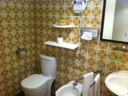
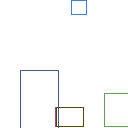
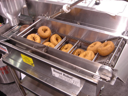
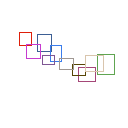
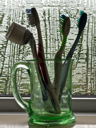
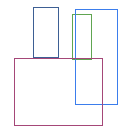
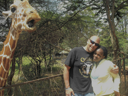
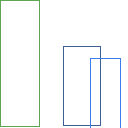
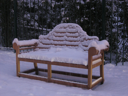
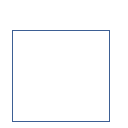

In [ ]:
tfds.as_dataframe(ds_train.take(5), info)

In [3]:
from torchvision.transforms import v2

/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Важно привести изображения к одному размеру 

In [4]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
from torch import nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, Bottleneck
from torchvision.models.resnet import ResNet152_Weights
from warnings import warn
import torchvision
class ResNet152(ResNet):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x =  self.layer4(x)
        x_for_attn = x = self.avgpool(x)
        x = nn.Flatten()(x)
        logits = x = self.fc(x)
        return x_for_attn, logits



Получим векторизацию изображений из фичей ResNet152, т.е. из предпоследнего слоя сети, до поносвязаного слоя

In [6]:
model = torchvision.models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

In [7]:
fetures_net = ResNet152(Bottleneck,[3, 8, 36, 3])
fetures_net.load_state_dict(model.state_dict())
fetures_net.train(False)

ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [8]:

features_net = fetures_net.to(device)

Сам цикл векторизации изображений, можно проспустить, т.к. есть сохраненая векторизация

In [9]:
img_code = []
captions = []
for e in tqdm(ds_train):
    image = e['image']
    caption = e['captions']['text'].numpy()

    image = torch.tensor(np.transpose(image, (2, 0, 1)), dtype=torch.float32,device=device)
   
    img_code.append(fetures_net(image.unsqueeze(dim = 0))[0].squeeze(dim = 0).detach().cpu().numpy())
    captions.append(caption)
with open('captions.pickle', 'wb') as f:
    pickle.dump(captions, f)
with open('img_code.pickle', 'wb') as f:
    pickle.dump(img_code, f)

NameError: name 'ds_train' is not defined

 После того как мы уже один раз получили ветороизацию изображений ее можно загружать из файлов

In [10]:
with open('captions.pickle', 'rb') as f:
    captions = pickle.load(f)
with open('img_code.pickle', 'rb') as f:
    img_code = pickle.load(f)

In [11]:
len(img_code)

82783

In [12]:
img_code[0].shape

(2048, 1, 1)

В качетстве токенизатора используем токенизатор от LaBSE. Приведем каждую подпись к строчному виду, и добавим метки начала и конца

In [13]:
from transformers import AutoTokenizer, AutoModel
from nltk.tokenize import RegexpTokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
#tokenizer = RegexpTokenizer('[a-zA-Z]+|[^\w\s]|\d+')

In [14]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i].decode("utf-8").lower()
        captions[img_i][caption_i] = ["#START#"]+tokenizer.tokenize(sentence)+["#END#"]

Для того чтобы ограничить словарь и не предсказывать на каждом шагу ветор размера миллион, добавим в словарь слова которые встречаются хотя бы $v$ раз. В нашем случае $v = 5$

In [15]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        word_counts.update(captions[img_i][caption_i])

In [16]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)


word_to_index = {w: i for i, w in enumerate(vocab)}

#Оказалось все несколько тысяч слов удволетворяют этому требованию

In [17]:
n_tokens

8515

Как и в первом задании каждая последовательность токенов должна иметь одинаковый размер, чтобы м ы могли составлять из них батчи 

In [18]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [19]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,  593,   83,   46,   18,   49,    4,  747,  151,  437,  601,
        2490,   16,    2],
       [   1,    4,  262,   56,   83,   18,   19,   20,   96,   24,   16,
           2,    3,    3],
       [   1,    4,  262,   56,   83, 1545,   49,  641, 1732,    2,    3,
           3,    3,    3],
       [   1,   83,   46,  264,   98, 1731,    8,   43,  275,   56,    4,
         314,   16,    2],
       [   1,  593,   83,   18,   60,   13, 1731,   49,   58,  561,   16,
           2,    3,    3]], dtype=int32)

## Строим нашу нейронную сеть

Как мы упоминали ранее, мы построим языковую модел rnn, основанную на фичах, полученных от сверточной части.

Начальную сеть мы распакуем позже, чтобы сэкономить память, а пока просто притворитесь, что она доступна.

In [20]:
import torch, torch.nn as nn
import torch.nn.functional as F

### Языковая модель

Преобразуем с помощью cnn изображение в фичи, которые подаются в слой внимание как ключи. Соотвественно пердыдущий скртый слой LSTM используется как запрос. На основе этого мы весов и эмбедингов мы получаем ветор контекста, который и подаем на вход LSTM. Рекурсивный процесс продолжается пока не обработаем всю строку

In [80]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=256, lstm_units=512, cnn_channels=2048):
        """ A recurrent 'head' network for image captioning. Read scheme below. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_channels, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_channels, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb =  nn.Embedding(n_tokens, emb_size)

        # attention: create attention over image spatial positions
        # The query is previous lstm hidden state, the keys are transformed cnn features,
        # the values are cnn features

        # attention: create transform from cnn features to the keys
        # Hint: one linear layer shoud work
        # Hint: the dimensionality of keys should be lstm_units as lstm
        #       hidden state is the attention query
        #self.cnn_to_attn_key = nn.Linear(cnn_channels, lstm_units)
        # lstm: create a recurrent core of your network. Use LSTMCell
        self.lstm = nn.LSTMCell(emb_size + cnn_channels, lstm_units)

        # create logits: MLP that takes attention response, lstm hidden state
        # and the previous word embedding as an input and computes one number per token
        # Hint: I used an architecture with one hidden layer, but you may try deeper ones
        #self.logits_mlp = nn.Linear((lstm_units + cnn_channels + emb_size), n_tokens )

        self.logits_mlp = nn.Sequential(
            nn.Linear(lstm_units , 2 * lstm_units ),
            nn.ReLU(2 * lstm_units ),
            nn.Linear(2 * lstm_units , n_tokens)
        )

    def forward(self, image_features, captions_ix):
        """
        Apply the network in training mode.
        :param image_features: torch tensor containing VGG features for each position.
                               shape: [batch, cnn_channels, width * height]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_features.mean(2))
        initial_hid = self.cnn_to_h0(image_features.mean(2))

        image_features = image_features.transpose(1, 2)

        # compute embeddings for captions_ix
        captions_emb =  self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. In the recurrent loop over tokens:
        #   2.1. transform image vectors to the keys for attention
        #   2.2. use previous lstm state as an attention query and image vectors as values
        #   2.3. apply attention to obtain context vector
        #   2.4. store attention map
        #   2.5. feed lstm with current token embedding concatenated with context vector
        #   2.6. update lstm hidden and cell vectors
        #   2.7. store current lstm hidden state, attention response, and the previous word embedding
        # reccurent_out should be lstm hidden state sequence
        # of shape [batch, caption_length, lstm_units + cnn_channels + emb_size]
        # attention_map should be attention maps sequence
        # of shape [batch, caption_length, width * height]
        reccurent_out = []
        attention_map = []

        # compute logits for next token probabilities
        # based on the stored in (2.7) values (reccurent_out)
        logits = []
        lstm_cell = initial_cell # shape = [batch, lstm_units]
        lstm_hidden_cell = initial_hid


        for i in range(captions_ix.shape[-1]):
            attn = image_features # shape = [batch, 1, cnn_channels]
            attn = torch.squeeze(attn, 1)
            context = torch.concatenate([attn, captions_emb[:, i]], dim = -1)
            (lstm_hidden_cell, lstm_cell) = self.lstm(context, (lstm_hidden_cell, lstm_cell))
            out = lstm_hidden_cell
            reccurent_out.append(out)
            logits_i = self.logits_mlp(out)
            logits.append(logits_i)

        logits = torch.stack(logits, dim = 1)
        # return logits and attention maps from (2.4)
        return logits

In [110]:
network = CaptionNet(n_tokens)

Проверим выход необученной сети

Генерация подписей

In [34]:
def generate_caption(image, caption_prefix = ("#START#",),
                     t=1, sample=True, max_len=10):

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32, device=device)

    vectors_9x9, logits = features_net(image[None])
    caption_prefix = list(caption_prefix)

    attention_maps = []

    for _ in range(max_len):

        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        input_features = vectors_9x9.view(vectors_9x9.shape[0], vectors_9x9.shape[1], -1)
        if next(network.parameters()).is_cuda:
            input_features, prefix_ix = input_features.cuda(), prefix_ix.cuda()
        else:
            input_features, prefix_ix = input_features.cpu(), prefix_ix.cpu()
        next_word_logits= network(input_features, prefix_ix)
        next_word_logits = next_word_logits[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().cpu().numpy()

        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs)
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break

    return caption_prefix

In [35]:
from matplotlib import pyplot as plt
from skimage.transform import resize
from tempfile import mktemp
from os import remove
%matplotlib inline

# get and preprocess image
def obtain_image(filename=None, url=None):
    if (filename is None and url is None) or (filename is not None and url is not None):
        raise ValueError('You shoud specify either filename or url')
    if url is not None:
        tmpfilename = mktemp()
        !wget {url} -O {tmpfilename} -q
        img = plt.imread(tmpfilename)
        remove(tmpfilename)
    else:
        img = plt.imread(filename)
    img = resize(img, (256, 256), mode='wrap', anti_aliasing=True).astype('float32')
    return img

def show_img(img):
    plt.imshow(img)
    plt.axis('off')

def print_possible_captions(img, num_captions=10, temperature=5.):
    for i in range(num_captions):
        print((' '.join(generate_caption(img, t=temperature)[1:-1])).replace(' ##', ''))


def process_image(img):
    show_img(img)
    print("Posible captions:")
    print_possible_captions(img)
    c = generate_caption(img, t=5.)
    print(f"Image caption: {c}")

Сначал проверим, что она дает выход в нужном формате

In [23]:
dummy_img_vec = torch.randn(len(captions[0]), 2048, 1)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)
dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('logits shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

logits shape: torch.Size([5, 19, 8515])


И проверим на одном изображении

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


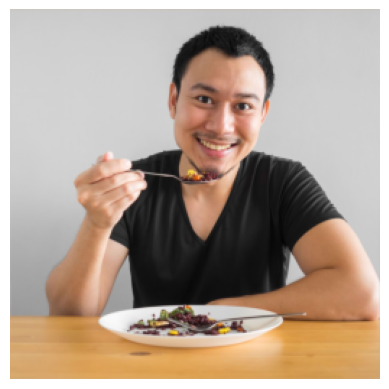

In [111]:
img = obtain_image(url="https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg")
show_img(img)

Posible captions:
swe travelersfia pike ' brings harvestlock mates
woven vegan sliced statementtte itself lost clog nearest
chur games material apr replaced address fighterub deciding
##zzling bolt autumn hooks bearingmpicture dropping bow
protester hospital manual diagram width stud vy futurecous
climatemagewing bornwheel wakegnut pins stores
target rifle die nakedcept needs girlfriend towel blu
drops colored booster crafts oft executive clean attracts airline
tople hipsnantsvoy sheet #PAD# powered casual uniforme
mel applying offs bulbs " colla had ware driven
Image caption: ['#START#', '##oli', 'tapes', 'ride', 'loi', 'calories', 'imi', '##dogs', 'point', 'getting', 'exchange']


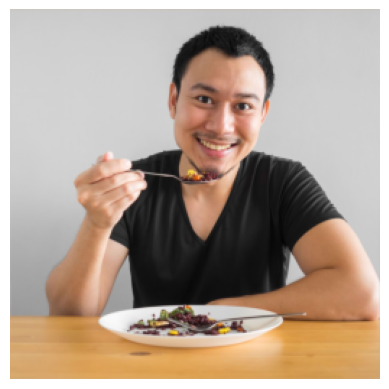

In [112]:
process_image(img)

#### Train loss function
Все таже кроссэнтропия но с регуляризатором на основе слоя внимания

In [113]:
def compute_loss(network, image_features, captions_ix):
    """
    :param image_features: torch tensor containing VGG features. shape: [batch, cnn_channels, width * height]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones plus
              attention regularizer. Scalar float tensor
    """

    if next(network.parameters()).is_cuda:
        image_features, captions_ix = image_features.cuda(), captions_ix.cuda()

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    # apply the network, get predictions, attnetion map and gates for captions_ix_next
    logits_for_next= network.forward(image_features, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = torch.nn.functional.cross_entropy(logits_for_next.transpose(1,2),captions_ix_next, ignore_index=pad_ix )

    # the regularizer for attention - this one requires the attention over each position to sum up to 1,
    # i. e. to look at the whole image during sentence generation process
    return loss 

#### Optimizer


In [114]:
optim = torch.optim.AdamW(network.parameters(), lr=0.001, weight_decay=0.01)

# Training



In [40]:
from torch.utils.data import Dataset

class IdxDataset(Dataset):
    def __init__(self, dataset, idx):
        self.dataset = dataset
        self.idx = idx

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        return self.dataset[self.idx[idx]]

In [41]:
# works in numpy 1.23.5
captions = np.array(captions, dtype=object)

np.random.seed(42)
perm = np.random.permutation(len(img_code))
threshold = round(len(img_code) * 0.1)
train_img_idx, val_img_idx = perm[threshold:], perm[: threshold]

train_img_idx.sort()
val_img_idx.sort()
train_img_codes = IdxDataset(img_code, train_img_idx)
val_img_codes = IdxDataset(img_code, val_img_idx)
train_captions = IdxDataset(captions, train_img_idx)
val_captions = IdxDataset(captions, val_img_idx)

In [121]:
from random import choice

last_batch_end = {}

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample sequential numbers for image/caption indicies (for trainign speed up)
    global last_batch_end
    random_image_ix = np.arange(batch_size, dtype='int') + last_batch_end.get(len(img_codes), 0)
    last_batch_end[len(img_codes)] = last_batch_end.get(len(img_codes), 0) + batch_size
    if last_batch_end[len(img_codes)] + batch_size >= len(img_codes):
        last_batch_end[len(img_codes)] = 0

    #get images
    batch_images = np.vstack([img_codes[i][None] for i in random_image_ix])
    batch_images = batch_images.reshape(batch_images.shape[0], batch_images.shape[1], -1)

    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [122]:
generate_batch(img_code, captions, 3)[1].shape

torch.Size([3, 15])

### Main loop

In [123]:
batch_size = 64 # adjust me
n_epochs = 32  # adjust me
n_batches_per_epoch = 1024 # adjust me
n_validation_batches = 16  # how many batches are used for validation after each epoch

In [124]:
torch.backends.cuda.matmul.allow_tf32 = True

In [125]:
generate_batch(val_img_codes, val_captions, batch_size)[0].shape

torch.Size([64, 2048, 1])

In [47]:
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 158322), started 0:03:41 ago. (Use '!kill 158322' to kill it.)

Обучим модель, графики доступны в tensorboard

In [126]:
writer = tf.summary.create_file_writer('./logs/run-2')
from tqdm import tqdm
step = 0
for epoch in range(n_epochs):
    if torch.cuda.is_available():
        network = network.cuda()

    train_loss=0
    network.train(True)
    with tqdm(range(n_batches_per_epoch)) as iterator:
        for _ in iterator:
            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
            
            # clear old gradients; do a backward pass to get new gradients; then train with opt
            # <YOUR CODE>
            optim.zero_grad()
            loss_t.backward()
            torch.nn.utils.clip_grad_norm_(network.parameters(), 1)
            optim.step()
            with writer.as_default():
                tf.summary.scalar('Loss', float(loss_t.detach().cpu()), step)
            step+=1
            train_loss += float(loss_t)
    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += float(loss_t)
    val_loss /= n_validation_batches

    if torch.cuda.is_available():
        network = network.cpu()

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss), flush=True)

print("Finished!")

100%|██████████| 1024/1024 [01:35<00:00, 10.78it/s]



Epoch: 0, train loss: 4.115410517435521, val loss: 3.6619708836078644


100%|██████████| 1024/1024 [01:40<00:00, 10.22it/s]



Epoch: 1, train loss: 3.5282531122211367, val loss: 3.455923840403557


100%|██████████| 1024/1024 [01:50<00:00,  9.29it/s]



Epoch: 2, train loss: 3.3316809048410505, val loss: 3.236800566315651


100%|██████████| 1024/1024 [01:35<00:00, 10.74it/s]



Epoch: 3, train loss: 3.2056673371698707, val loss: 3.194256290793419


100%|██████████| 1024/1024 [01:27<00:00, 11.77it/s]



Epoch: 4, train loss: 3.1222491862718016, val loss: 3.152117282152176


100%|██████████| 1024/1024 [02:23<00:00,  7.14it/s]



Epoch: 5, train loss: 3.0508126139175147, val loss: 3.11165851354599


100%|██████████| 1024/1024 [02:11<00:00,  7.76it/s]



Epoch: 6, train loss: 3.0092782862484455, val loss: 3.0163092762231827


100%|██████████| 1024/1024 [01:11<00:00, 14.40it/s]



Epoch: 7, train loss: 2.9677955971565098, val loss: 2.9709710627794266


100%|██████████| 1024/1024 [01:35<00:00, 10.71it/s]



Epoch: 8, train loss: 2.9341366165317595, val loss: 2.9470035284757614


100%|██████████| 1024/1024 [01:16<00:00, 13.39it/s]



Epoch: 9, train loss: 2.910130915697664, val loss: 3.04723097383976


100%|██████████| 1024/1024 [00:57<00:00, 17.69it/s]



Epoch: 10, train loss: 2.8886569552123547, val loss: 2.9334608614444733


100%|██████████| 1024/1024 [00:45<00:00, 22.50it/s]



Epoch: 11, train loss: 2.862143874168396, val loss: 2.9684928357601166


100%|██████████| 1024/1024 [00:46<00:00, 22.16it/s]



Epoch: 12, train loss: 2.8456038013100624, val loss: 2.938672259449959


100%|██████████| 1024/1024 [00:45<00:00, 22.34it/s]



Epoch: 13, train loss: 2.8283362765796483, val loss: 2.930227652192116


100%|██████████| 1024/1024 [01:04<00:00, 15.95it/s]



Epoch: 14, train loss: 2.8123622266575694, val loss: 2.9665655195713043


100%|██████████| 1024/1024 [00:50<00:00, 20.39it/s]



Epoch: 15, train loss: 2.7991100733634084, val loss: 2.9108721911907196


100%|██████████| 1024/1024 [01:03<00:00, 16.04it/s]



Epoch: 16, train loss: 2.7915628489572555, val loss: 2.929291218519211


100%|██████████| 1024/1024 [01:05<00:00, 15.58it/s]



Epoch: 17, train loss: 2.7755017783492804, val loss: 2.971201330423355


100%|██████████| 1024/1024 [01:46<00:00,  9.61it/s]



Epoch: 18, train loss: 2.7673886055126786, val loss: 2.900268077850342


100%|██████████| 1024/1024 [01:07<00:00, 15.20it/s]



Epoch: 19, train loss: 2.7641861136071384, val loss: 2.8848692029714584


100%|██████████| 1024/1024 [01:23<00:00, 12.23it/s]



Epoch: 20, train loss: 2.750533959362656, val loss: 2.917166516184807


100%|██████████| 1024/1024 [01:50<00:00,  9.23it/s]



Epoch: 21, train loss: 2.7408972426783293, val loss: 2.970266819000244


100%|██████████| 1024/1024 [01:23<00:00, 12.22it/s]



Epoch: 22, train loss: 2.732551737455651, val loss: 2.8643174320459366


100%|██████████| 1024/1024 [01:28<00:00, 11.53it/s]



Epoch: 23, train loss: 2.725800396874547, val loss: 2.946821942925453


100%|██████████| 1024/1024 [01:11<00:00, 14.25it/s]



Epoch: 24, train loss: 2.7211797528434545, val loss: 2.885302171111107


100%|██████████| 1024/1024 [01:01<00:00, 16.64it/s]



Epoch: 25, train loss: 2.7099284210707992, val loss: 2.8927849382162094


100%|██████████| 1024/1024 [01:32<00:00, 11.11it/s]



Epoch: 26, train loss: 2.705557090230286, val loss: 2.8428047597408295


100%|██████████| 1024/1024 [01:37<00:00, 10.50it/s]



Epoch: 27, train loss: 2.701216947287321, val loss: 2.9469840228557587


100%|██████████| 1024/1024 [00:59<00:00, 17.35it/s]



Epoch: 28, train loss: 2.690070011653006, val loss: 2.9181963950395584


100%|██████████| 1024/1024 [00:58<00:00, 17.37it/s]



Epoch: 29, train loss: 2.6891292575746775, val loss: 2.9488871097564697


100%|██████████| 1024/1024 [01:11<00:00, 14.38it/s]



Epoch: 30, train loss: 2.676793246762827, val loss: 2.882508799433708


100%|██████████| 1024/1024 [01:03<00:00, 16.11it/s]



Epoch: 31, train loss: 2.672602051636204, val loss: 2.9604291766881943
Finished!


In [127]:
torch.save(network.state_dict(), 'network.pt')

А теперь посмотрим на выход обученной сети

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


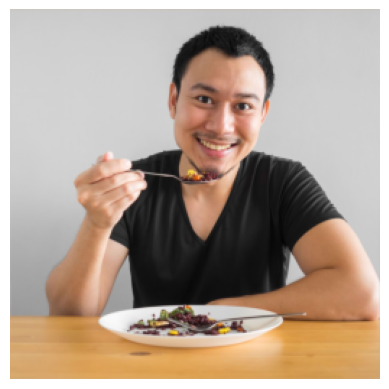

In [128]:
img = obtain_image(url="https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg")
show_img(img)

Posible captions:
a small room
a small room
a small room
a small room
a small room
a small room
a small room
a small room
a small room
a small room
Image caption: ['#START#', 'a', 'small', 'room', '#END#']


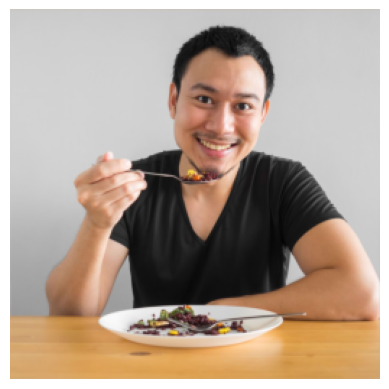

In [129]:
process_image(img)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a street with a large clock on the dark
a street with a large clock .
a clock with a clock on the dark street
a street with a large clock .
a large clock with a clock .
a light that is in a dark street .
a large clock with a clock .
a street with a clock on the dark street
a street with a large clock .
a street with a large clock on the dark
Image caption: ['#START#', 'a', 'bunch', 'of', 'street', 'light', '.', '#END#']


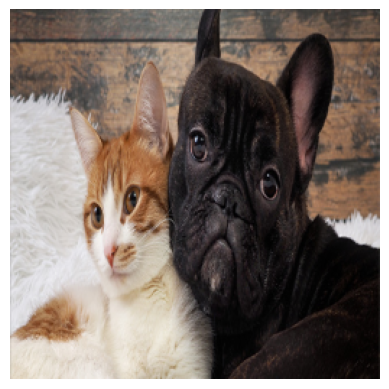

In [130]:
process_image(obtain_image(url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg"))

# Вывод 

В целом даже при обучении на небольшом датасете удается получить подписи к картинкам, основная проблем с тем, что получается либо слишком длинные аннотации, либо получаются слова не из словаря. Лучше всего при маленьком наборе данных использовать токенизатор из предудущих заданий, т.к. токенизатор по словам часто получает #UNK#

# Результаты на изображениях из интернета

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a large white and red and red and red
a large white and red and red and red
a person standing with a large stop .
a large dark street .
a large dark street .
a street with a ski .
a large white and red and red and red
a large white and red and red and red
a large dark street with a stop .
a large dark street .
Image caption: ['#START#', 'a', 'large', 'white', 'and', 'red', 'and', 'red', 'and', 'red', 'light']


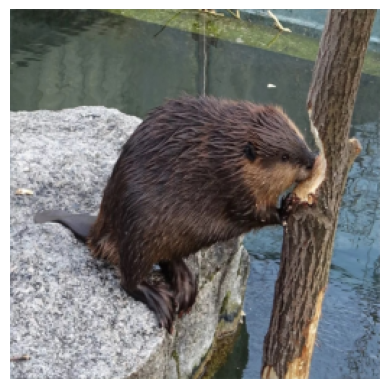

In [131]:
process_image(obtain_image(url="https://pushkinsdelal.ru/wp-content/uploads/2023/01/bobr.jpg"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a dark street with a clock .
a dark street with a clock .
a dark street with a clock .
a dark street with a clock .
a large white and red and red and red
a dark street with a stop light .
a large dark street
a dark street with a clock .
a dark street with a clock .
a dark street with a clock .
Image caption: ['#START#', 'a', 'dark', 'street', 'with', 'a', 'clock', '.', '#END#']


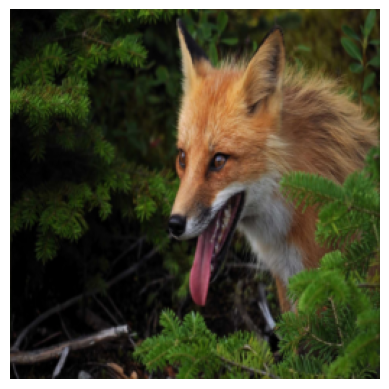

In [132]:
process_image(obtain_image(url="https://haski-mana.ru/wp-content/uploads/0/e/4/0e453b22b9011fc673687053ac3f1dab.jpeg"))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a large white and red and red and red
a large white and red and red and red
a dark street with a large white and red
a dark street with a red and red and
a large white and red and red and red
a dark street with a large white and red
a dark street with white and red and red
a dark street with a large white and red
a dark picture of a large and red and
a dark street with white and red and red
Image caption: ['#START#', 'a', 'large', 'white', 'and', 'red', 'and', 'red', 'and', 'red', 'and']


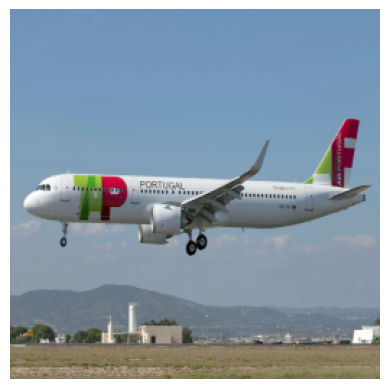

In [133]:
process_image(obtain_image(url="https://upload.wikimedia.org/wikipedia/commons/8/8a/TAP_Air_Portugal_Airbus_A321-251N_at_Faro_Airport.jpg"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a large clock .
a large clock .
a light with a red and red and red
a dark street with a ski .
a dark street with a ski .
a light with a red and white and red
a light with a red and red and red
a large clock .
a light that is flying up in the dark
a red and white and red and red and
Image caption: ['#START#', 'a', 'clock', 'with', 'a', 'red', 'and', 'red', 'and', 'red', 'and']


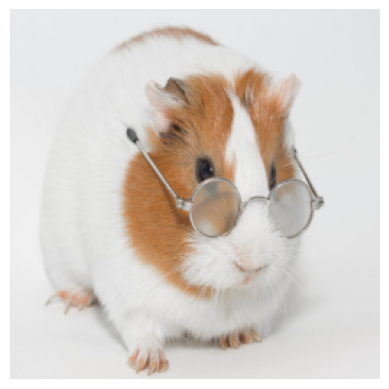

In [134]:
process_image(obtain_image(url="http://kartinkof.club/uploads/posts/2022-04/1649921845_8-kartinkof-club-p-rzhachnie-kartinki-khomyak-v-ochkakh-8.jpg"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a white and white and red and red and
a white and red and red and red with
a white and white and red and red and
a large white and red and red and red
a white and white and red and red and
a white and white and red and red and
a white and white and red and red and
a white and red and red and red and
a white and white and red and red and
a white and red and red and red and
Image caption: ['#START#', 'a', 'white', 'and', 'red', 'and', 'red', 'and', 'red', 'and', 'red']


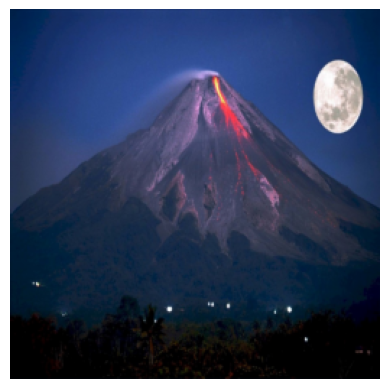

In [135]:
process_image(obtain_image(url="https://cdn.regnum.ru/uploads/pictures/news/2019/01/14/regnum_picture_1547449546144744_normal.jpg"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a red street with a red and red and
a red street with a clock on a dark
a red street with a red street with a
a street with a clock on a dark street
a red street with a clock and clock on
a large white and red and red street with
a large white and red and red and red
a street with a clock and a clock with
a large white and red and red and red
a red and black street with a clock with
Image caption: ['#START#', 'a', 'street', 'with', 'a', 'clock', 'and', 'a', 'clock', 'with', 'a']


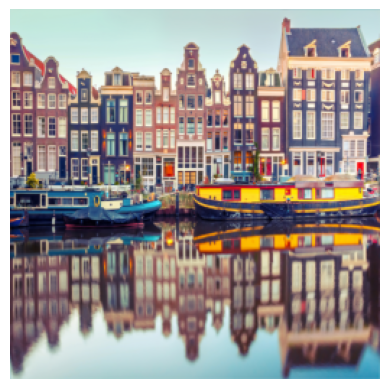

In [136]:
process_image(obtain_image(url='https://plintus.spb.ru/wp-content/uploads/2021/03/fotooboi-kanal-amsterdama.jpg'))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a dark street with a skier is on
a dark street with a skier on the
a dark street with a large white and red
a street with a stop sign lit with a
a dark street with a ski and a ski
a dark street with a skier is on
a dark street with a ski and a dark
a dark street with a ski and a stop
a street with a stop sign lit with a
a blurry picture of a dark street with
Image caption: ['#START#', 'a', 'dark', 'street', 'with', 'a', 'ski', 'and', 'a', 'red', 'and']


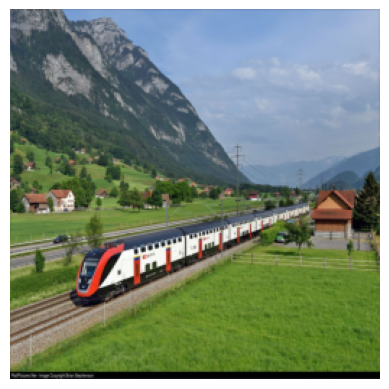

In [137]:
process_image(obtain_image(url='https://i.pinimg.com/originals/0a/38/f8/0a38f88cb3f45cc9b05c8245ad69f880.jpg'))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a large white and white and white and red
a large black and white and white and red
a large black and white and white and red
a small white and white and red and white
a very tall and white and black and white
a large white and black and white and white
a large black and white and red and white
a pair of white and white and red and
a large white and white and red and white
a large black and white and white and red
Image caption: ['#START#', 'a', 'red', 'and', 'white', 'and', 'white', 'and', 'red', 'and', 'white']


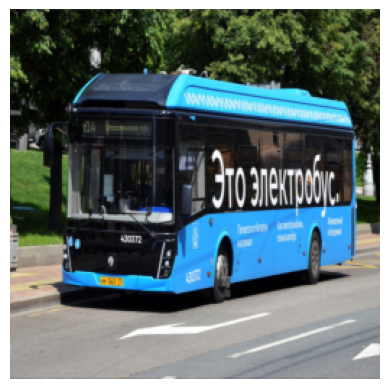

In [138]:
process_image(obtain_image(url='https://www.ugorizont.ru/wp-content/uploads/sites/39/2021/08/5eea293382682c271a7f6bbb-scaled.jpg'))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Posible captions:
a dark picture of a wine .
a dark picture of a wine .
a dark picture of a wine .
a dark picture of a wine .
a dark picture of a wine .
a dark picture of a wine .
a dark picture of a wine .
a dark bowl with a clock .
a dark bowl with a black and black and
a dark picture of a wine .
Image caption: ['#START#', 'a', 'dark', 'picture', 'of', 'a', 'wine', '.', '#END#']


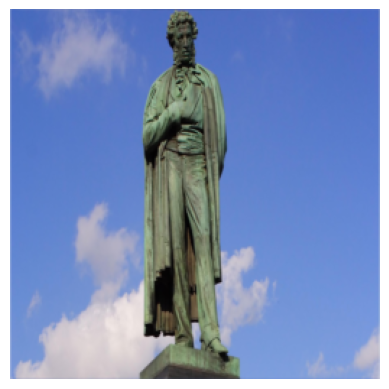

In [139]:
process_image(obtain_image(url='https://regnum.ru/uploads/pictures/news/2017/03/28/regnum_picture_1490685172215644_normal.jpg'))

### Выводы

Добавление слоев в self.cnn_to_attn_key позволяет нейросети разбирать картинки с большим кол-вом деталей. Без в картинке с большим кол-вом кексов получалось совершенно неинформативное описание.

Добавление слоев в self.logits_mlp улучшает сопаставление предметов. Например, первая картинка теперь выдает точное описание, хотя до этого она добавляла в описанеи предметы, которых просто не было.

ReLU себя показала хуже, чем более гладкие функции активации, т.к. выдавла более острые границы и соответсвенно теряла в детализации. SiLU соответсвенно показала себя лучше, т.к. она явлется гладкой и не имеет нулевых градиентов.

В целом небольшое усложнение слоев с увеличением размера batch_size позволяет лучше составлять описание для картинок с большим количеством деталей и лучше улавливается контекст.
Но все еще неправильно распознаются похожие животные (лиса выдается за собаку, а бобра за медведя) и иногда появляются предметы которых нет (в картинке с автобусом появлется машина)